### Import basic libraries

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

### Load in the dataframe

In [2]:
df = pd.read_pickle('./main_df.pkl')
print(df.shape)
df.head()

(2213180, 14)


,virus,host,blastn,crisprdetect-2mismatch,gc_content,k25,k6-chebyshev,k6-kendalltau,k6-manhattan,piler-2mismatch,wish,group,group_code,y
0,NC_010363,NC_008527,60.8,0.0,0.021973,0.0,0.002122,0.398421,0.382144,0.0,-1.33553,Streptococcaceae,41,1
1,NC_010363,NC_002662,59.0,0.0,0.016709,0.0,0.001929,0.397773,0.377498,0.0,-1.33035,Streptococcaceae,41,1
2,NC_010363,NC_017949,59.0,0.0,0.020818,0.0,0.002088,0.396969,0.379686,0.0,-1.33341,Streptococcaceae,41,1
3,NC_010363,NC_017492,59.0,0.0,0.022209,0.0,0.002131,0.396148,0.380930,0.0,-1.33767,Streptococcaceae,41,1
4,NC_010363,NC_009004,59.0,0.0,0.020871,0.0,0.002088,0.397095,0.379834,0.0,-1.33341,Streptococcaceae,41,1


## Data preprocessing

### Get all of positive cases + the same number of negative cases randomly

In [3]:
# get all the positive cases
learning_df = df[df['y'] == 1]
# get the same amount of negative cases RANDOMLY
negative_learning_df = df[df['y'] == 0].sample(n=len(df[df['y'] == 1].index))

learning_df = pd.concat([learning_df, negative_learning_df], ignore_index=True)
print(learning_df.shape)
learning_df.head()

(33514, 14)


,virus,host,blastn,crisprdetect-2mismatch,gc_content,k25,k6-chebyshev,k6-kendalltau,k6-manhattan,piler-2mismatch,wish,group,group_code,y
0,NC_010363,NC_008527,60.8,0.0,0.021973,0.0,0.002122,0.398421,0.382144,0.0,-1.33553,Streptococcaceae,41,1
1,NC_010363,NC_002662,59.0,0.0,0.016709,0.0,0.001929,0.397773,0.377498,0.0,-1.33035,Streptococcaceae,41,1
2,NC_010363,NC_017949,59.0,0.0,0.020818,0.0,0.002088,0.396969,0.379686,0.0,-1.33341,Streptococcaceae,41,1
3,NC_010363,NC_017492,59.0,0.0,0.022209,0.0,0.002131,0.396148,0.380930,0.0,-1.33767,Streptococcaceae,41,1
4,NC_010363,NC_009004,59.0,0.0,0.020871,0.0,0.002088,0.397095,0.379834,0.0,-1.33341,Streptococcaceae,41,1


### Groups dristribution

NOTE: evening out the differences in group compositions will be added later

In [4]:
learning_df[['group','group_code']].value_counts()

group                                              group_code
Enterobacteriaceae                                 16            12651
Staphylococcaceae                                  40             4883
Pseudomonadaceae                                   34             2914
Streptococcaceae                                   41             2172
Bacillaceae                                        5              1584
Burkholderiaceae                                   9              1217
Vibrionaceae                                       46             1107
Listeriaceae                                       22              935
Propionibacteriaceae                               33              629
Mycobacteriaceae                                   25              596
Xanthomonadaceae                                   47              470
Lactobacillaceae                                   20              398
Enterococcaceae                                    17              314
Helicobacterace

In [5]:
learning_df[learning_df['y'] == 1][['group', 'group_code']].value_counts()

group                                              group_code
Enterobacteriaceae                                 16            8419
Staphylococcaceae                                  40            3342
Pseudomonadaceae                                   34            1012
Streptococcaceae                                   41             782
Listeriaceae                                       22             624
Bacillaceae                                        5              454
Vibrionaceae                                       46             436
Burkholderiaceae                                   9              342
Helicobacteraceae                                  19             212
Propionibacteriaceae                               33             211
Mycobacteriaceae                                   25             156
Moraxellaceae                                      24             113
Lactobacillaceae                                   20              74
Xanthomonadaceae            

### Encode categorical values

*Note: encoding not needed because training is not based on virus and host names*

In [ ]:
'''
transformed_data = pd.get_dummies(filled_df, columns=['virus', 'host'])
transformed_data
'''

### Extract X and y arrays

In [6]:
'''
X = learning_df.drop(['virus', 'host', 'group', 'group_code', 'y'], axis=1).values
y = learning_df['y'].values
'''

X = learning_df.drop(['virus', 'host', 'group', 'group_code', 'y'], axis=1)
y = learning_df['y']
groups = learning_df['group_code'].values

print(f'shape of X: {X.shape}')
print(f'len(y): {len(y)}')

shape of X: (33514, 9)
len(y): 33514


Get groups for LeaveOneGroupOut

In [30]:
groups = learning_df['group_code'].values

### test_train_split

In [7]:
# SIMPLE SPLIT
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25)

### Feature scaling (if necessary) 

### Train the Random Forst Classifier

In [8]:
# ONLY FOR SIMPLE SPLIT USE
from sklearn.ensemble import RandomForestClassifier
classifier = RandomForestClassifier(n_estimators = 200, max_depth=4, criterion = 'entropy', random_state = 1)
classifier.fit(X_train, y_train)

RandomForestClassifier(criterion='entropy', max_depth=4, n_estimators=200,
                       random_state=1)

### Predict Test set results

In [10]:
y_pred = classifier.predict(X_test)

## Scoring the model

### Confusion Matrix

In [13]:
from sklearn.metrics import confusion_matrix, accuracy_score
cm = confusion_matrix(y_test, y_pred)
print(cm)
print(f'Accuracy: {accuracy_score(y_test, y_pred):.2f}')

[[3786  364]
 [ 707 3522]]
Accuracy: 0.87


### ROC curve

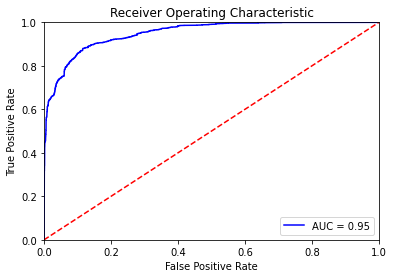

In [14]:
import sklearn.metrics as metrics
# calculate the fpr and tpr for all thresholds of the classification
probs = classifier.predict_proba(X_test)
preds = probs[:,1]
fpr, tpr, threshold = metrics.roc_curve(y_test, preds)
roc_auc = metrics.auc(fpr, tpr)

# method I: plt
import matplotlib.pyplot as plt
plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

*Note: conclusion: ROC curve is a bad method to evaluate this kind of data*

### Precision-recall curve

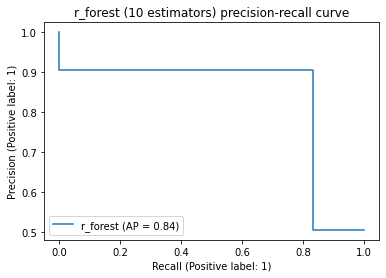

In [15]:
from sklearn.metrics import PrecisionRecallDisplay
display = PrecisionRecallDisplay.from_predictions(y_test, y_pred, name="r_forest")
_ = display.ax_.set_title("r_forest (10 estimators) precision-recall curve")

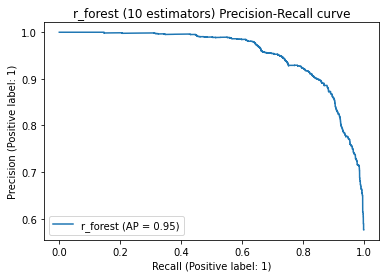

In [16]:
display = PrecisionRecallDisplay.from_estimator(
    classifier, X_test, y_test, name="r_forest"
)
_ = display.ax_.set_title("r_forest (10 estimators) Precision-Recall curve")

## F1 score

In [17]:
print(cm)
accuracy_score(y_test, y_pred)

[[3786  364]
 [ 707 3522]]


0.8721804511278195

### Calculate precision and recall

In [21]:
from sklearn.metrics import precision_score, recall_score
print(f'Precision is: {precision_score(y_test, y_pred):.2f}')
print(f'Recall is: {recall_score(y_test, y_pred):.2f}')

Precision is: 0.91
Recall is: 0.83


### F1 score for this model 

In [22]:
from sklearn.metrics import f1_score
print(f'F1 is: {f1_score(y_test, y_pred):.2f}')

F1 is: 0.87


*Note: the model still has a very good score*

*Ideas as to why:* 
1. *Now there is enough data to train the model - ca. 16,5k positive cases + 16,5k randomly chosen negative ones*
    * _to get learning_df closer to natural, a different method (learning for unbalanced set - ___stratified sampling___) will probably be needed_ 
2. *Still huge host and phage in-group similarity (hosts often with only a few nucleotide difference in genome) - not adressed!* 
3. *Randomly chosen 'good' negative cases?*

# Training using cross validation

### Using cross_val_score function

In [6]:
'''
# Leave one group out split
from sklearn.model_selection import LeaveOneGroupOut
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestClassifier

# create logo cv procedure
logo = LeaveOneGroupOut()
# create model
model = RandomForestClassifier(n_estimators = 10, criterion = 'entropy', random_state=1)
# evaluate model
scores = cross_val_score(model, X, y, scoring='f1', cv=logo, groups=groups, n_jobs=-1)
# report performance
print(f'Mean F1 score: {np.mean(scores):.3f}, stdev: ({np.std(scores):.3f})')
'''

Mean F1 score: 0.566, stdev: (0.320)


### Using cross_validate function

In [5]:
from sklearn.model_selection import LeaveOneGroupOut
from sklearn.model_selection import cross_validate
from sklearn.ensemble import RandomForestClassifier

# determine the scoring method
scoring = ['f1']
# create logo cv procedure
logo = LeaveOneGroupOut()
# create model
model = RandomForestClassifier(n_estimators = 10, criterion = 'entropy', random_state=1)
# evaluate model
results = cross_validate(model, X, y, scoring=scoring, 
                        cv=logo, groups=groups, n_jobs=-1, return_estimator=True)

In [8]:
results.keys()

dict_keys(['fit_time', 'score_time', 'estimator', 'test_f1'])

In [9]:
results['test_f1']

array([0.66666667, 0.66666667, 0.        , 0.9       , 0.33333333,
       0.62008734, 0.44444444, 0.        , 0.66666667, 0.60818713,
       0.39215686, 0.75      , 0.03076923, 0.77894737, 0.        ,
       0.        , 0.53096586, 0.68518519, 0.8       , 1.        ,
       0.8125    , 0.55555556, 0.90611542, 0.        , 0.575     ,
       0.68292683, 0.88888889, 1.        , 0.45454545, 0.        ,
       0.92929293, 0.91489362, 0.28571429, 0.296     , 0.33570863,
       0.91666667, 0.44444444, 1.        , 0.8       , 0.        ,
       0.88719815, 0.86373166, 0.47058824, 0.72727273, 0.66666667,
       1.        , 0.39564428, 0.48484848])

In [40]:
len(results['estimator'])

48

## Get probabilities of class assignment for each element in main_df

for each estimator:
1. take the viruses from the test part of the estimator
2. for each of this virus estimate class for ALL the bacteria in main_df
3. check if estimation was correct
4. take best predictions (highest probabilities) for each virus
5. write these predictions down

### For learning_df:

Order of classification probabilities corresponds to the order of class labels in .classes_ attribute

In [6]:
results['estimator'][0].classes_

array([0, 1], dtype=int64)

In [6]:
prob_df = pd.DataFrame(index=range(len(learning_df['y'])), columns=['0', '1'])
for i in range(0, max(groups)+1):
    mask = groups == i
    prob_df.loc[mask, ['0', '1']] = results['estimator'][i].predict_proba(X.loc[mask,:])

In [7]:
'''
prob = learning_df.apply(lambda row:
            results['estimator'][row['group_code']]
            .predict_proba(X[row.name:row.name+1]), axis=1)

prob_df2 = pd.DataFrame(prob)
prob_df2.columns = ['_']

pr_0 = []
pr_1 = []
for el in prob_df2['_']:
    pr_0.append(el[0][0])
    pr_1.append(el[0][1])

prob_df2['0'] = pr_0
prob_df2['1'] = pr_1

prob_df2.drop('_', inplace=True, axis=1)
prob_df2.compare(prob_df, align_axis=True, keep_equal=True)
'''

Empty DataFrame
Columns: []
Index: []

Put them into the learning_df

In [13]:
learning_df.insert(loc=len(learning_df.columns)-1, column='prob',value=prob)

Assess if estimator classification was correct and put the result to learning_df

In [14]:
learning_df.insert(loc=len(learning_df.columns)-1, column='estimator_correct', value=
    [1 if learning_df.iloc[i, -1] == np.argmax(el) else 0 for i, el in enumerate(prob)])

Take the part of learning_df where estimator was correct

In [15]:
correct_df = learning_df[learning_df['estimator_correct'] == 1]

Determine best hosts for each virus - ones with the highest probabilities (and correct classification) 

In [16]:
viruses = pd.unique(correct_df['virus'])
best_hosts = {}
for vir in viruses:
    best_hosts[vir] = {}
    best_hosts[vir]['hosts'] = []
    vir_max_prob = max(correct_df[correct_df['virus'] == vir]
                                ['prob'].apply(lambda vals: np.amax(vals)))
    for _, row in correct_df[correct_df['virus'] == vir].iterrows():
        if np.amax(row['prob']) == vir_max_prob:
            best_hosts[vir]['hosts'].append((row['host'], np.amax(row['prob'])))


In [93]:
best_hosts

{'NC_013599': {'hosts': [('NC_010513', 1.0),
   ('NC_004556', 1.0),
   ('NC_010577', 1.0),
   ('NC_017562', 1.0),
   ('NC_002488', 1.0),
   ('NC_017146', 1.0),
   ('NC_017250', 1.0),
   ('NC_018619', 1.0),
   ('NC_008819', 1.0),
   ('NC_008062', 1.0),
   ('NC_017247', 1.0),
   ('NC_021894', 1.0),
   ('NC_009785', 1.0),
   ('NC_009338', 1.0),
   ('NC_007204', 1.0),
   ('NC_005043', 1.0),
   ('NC_017046', 1.0)]},
 'NC_021863': {'hosts': [('NC_009632', 1.0),
   ('NC_009487', 1.0),
   ('NC_017341', 1.0),
   ('NC_022604', 1.0),
   ('NC_021670', 1.0),
   ('NC_017331', 1.0),
   ('NC_021554', 1.0),
   ('NC_017349', 1.0),
   ('NC_009641', 1.0),
   ('NC_007795', 1.0),
   ('NC_013450', 1.0),
   ('NC_017351', 1.0),
   ('NC_002758', 1.0),
   ('NC_009782', 1.0),
   ('NC_017340', 1.0),
   ('NC_007622', 1.0),
   ('NC_022113', 1.0),
   ('NC_016928', 1.0),
   ('NC_022442', 1.0),
   ('NC_017337', 1.0),
   ('NC_017333', 1.0),
   ('NC_020568', 1.0),
   ('NC_020566', 1.0),
   ('NC_020564', 1.0),
   ('NC_020

### For main df:

Create X, y and groups sets for the main df

In [6]:
X_main = df.drop(['virus', 'host', 'group', 'group_code', 'y'], axis=1)
y_main = df['y']
groups_main = df['group_code'].values

Check if each subgroup contains all the hosts

In [7]:
hosts_num = len(pd.unique(df.loc[:, 'host']))
for i in range(0, max(groups_main)+1):
    if len(pd.unique(df.loc[groups_main == i, 'host'])) != hosts_num:
        print(f'ERROR: not enough hosts in subgroup {i} (hosts: {len(pd.unique(df.loc[groups_main == i, "host"]))})!')

Calculate the probabilities of classification for viruses in each of the test sets (i.e. where groups_main == i)

In [8]:
prob_df_main = pd.DataFrame(index=range(len(df['y'])), columns=['0', '1'])
prob_df_main['0'] = prob_df_main['0'].astype('float')
prob_df_main['1'] = prob_df_main['1'].astype('float')
for i in range(0, max(groups_main)+1):
    mask_main = groups_main == i
    prob_df_main.loc[mask_main, ['0', '1']] = results['estimator'][i].predict_proba(X_main.loc[mask_main,:])

Create a df with the results

In [9]:
df_all = pd.concat([df, prob_df_main], axis=1)

In [10]:
df_all.head()

,virus,host,blastn,crisprdetect-2mismatch,gc_content,k25,k6-chebyshev,k6-kendalltau,k6-manhattan,piler-2mismatch,wish,group,group_code,y,0,1
0,NC_010363,NC_008527,60.8,0.0,0.021973,0.0,0.002122,0.398421,0.382144,0.0,-1.33553,Streptococcaceae,41,1,0.9,0.1
1,NC_010363,NC_002662,59.0,0.0,0.016709,0.0,0.001929,0.397773,0.377498,0.0,-1.33035,Streptococcaceae,41,1,0.8,0.2
2,NC_010363,NC_017949,59.0,0.0,0.020818,0.0,0.002088,0.396969,0.379686,0.0,-1.33341,Streptococcaceae,41,1,0.8,0.2
3,NC_010363,NC_017492,59.0,0.0,0.022209,0.0,0.002131,0.396148,0.380930,0.0,-1.33767,Streptococcaceae,41,1,0.9,0.1
4,NC_010363,NC_009004,59.0,0.0,0.020871,0.0,0.002088,0.397095,0.379834,0.0,-1.33341,Streptococcaceae,41,1,0.8,0.2


Check if there indeed are all the expected predictions (2699 hosts for each virus)

In [11]:
hosts_num = len(pd.unique(df['host']))
for i, el in enumerate(df_all.groupby('virus')['host'].count()):
    if el != hosts_num:
        print(f'Error for virus {i}')

Determine if the predition was correct

In [12]:
df_all['estimator_correct'] = df['y']
df_all['estimator_correct'] = df_all['estimator_correct'].astype(bool)
mask = df_all['y'] == 0
df_all.loc[mask,'estimator_correct'] = df_all['0'] > df_all['1']
df_all.loc[mask, 'prob'] = df_all['0']
mask = df_all['y'] == 1
df_all.loc[mask, 'estimator_correct'] = df_all['1'] > df_all['0']
df_all.loc[mask, 'prob'] = df_all['1']
df_all['prob'] = df_all['prob'].astype('float')

In [13]:
df_all.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2213180 entries, 0 to 2213179
Data columns (total 18 columns):
 #   Column                  Dtype   
---  ------                  -----   
 0   virus                   object  
 1   host                    object  
 2   blastn                  float64 
 3   crisprdetect-2mismatch  float64 
 4   gc_content              float64 
 5   k25                     float64 
 6   k6-chebyshev            float64 
 7   k6-kendalltau           float64 
 8   k6-manhattan            float64 
 9   piler-2mismatch         float64 
 10  wish                    float64 
 11  group                   category
 12  group_code              category
 13  y                       int64   
 14  0                       float64 
 15  1                       float64 
 16  estimator_correct       bool    
 17  prob                    float64 
dtypes: bool(1), category(2), float64(12), int64(1), object(2)
memory usage: 341.0+ MB


In [14]:
df_all[(df_all['y'] == 1) & (df_all['estimator_correct'] == True)]

,virus,host,blastn,crisprdetect-2mismatch,gc_content,k25,k6-chebyshev,k6-kendalltau,k6-manhattan,piler-2mismatch,wish,group,group_code,y,0,1,estimator_correct,prob
225,NC_013599,NC_010513,9281.0,0.0,0.048394,4917.0,0.001123,0.466373,0.343648,0.0,-1.37070,Xanthomonadaceae,47,1,0.2,0.8,True,0.8
226,NC_013599,NC_004556,8473.0,0.0,0.049805,8718.0,0.001119,0.468682,0.345848,0.0,-1.37728,Xanthomonadaceae,47,1,0.2,0.8,True,0.8
227,NC_013599,NC_010577,8473.0,0.0,0.050001,8747.0,0.001118,0.469334,0.346064,0.0,-1.37748,Xanthomonadaceae,47,1,0.2,0.8,True,0.8
228,NC_013599,NC_017562,8471.0,0.0,0.049755,8565.0,0.001122,0.469839,0.346372,0.0,-1.37730,Xanthomonadaceae,47,1,0.2,0.8,True,0.8
229,NC_013599,NC_002488,4387.0,0.0,0.040827,2771.0,0.001057,0.441785,0.325658,0.0,-1.36647,Xanthomonadaceae,47,1,0.0,1.0,True,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1918120,NC_022747,NC_012580,0.0,0.0,0.017472,0.0,0.000876,0.348632,0.267534,0.0,-1.38087,Vibrionaceae,46,1,0.4,0.6,True,0.6
1918122,NC_022747,NC_016446,0.0,0.0,0.017645,0.0,0.000882,0.348521,0.268030,0.0,-1.38096,Vibrionaceae,46,1,0.4,0.6,True,0.6
1918137,NC_022747,NC_016945,0.0,0.0,0.018640,0.0,0.000884,0.352812,0.270277,0.0,-1.38213,Vibrionaceae,46,1,0.4,0.6,True,0.6
1918138,NC_022747,NC_002506,0.0,0.0,0.018696,0.0,0.000884,0.352786,0.270271,0.0,-1.38208,Vibrionaceae,46,1,0.4,0.6,True,0.6


In [15]:
correct_df = df_all[df_all['estimator_correct'] == True]
correct_df

,virus,host,blastn,crisprdetect-2mismatch,gc_content,k25,k6-chebyshev,k6-kendalltau,k6-manhattan,piler-2mismatch,wish,group,group_code,y,0,1,estimator_correct,prob
6,NC_010363,NC_012438,57.2,0.0,0.009055,0.0,0.002532,0.515620,0.588794,0.0,-1.35836,Streptococcaceae,41,0,0.8,0.2,True,0.8
7,NC_010363,NC_006814,53.6,0.0,0.010561,0.0,0.001443,0.445837,0.412691,0.0,-1.34041,Streptococcaceae,41,0,1.0,0.0,True,1.0
8,NC_010363,NC_021181,53.6,0.0,0.010478,0.0,0.001445,0.445844,0.412664,0.0,-1.34044,Streptococcaceae,41,0,1.0,0.0,True,1.0
9,NC_010363,NC_021721,53.6,0.0,0.125869,0.0,0.003324,0.691869,0.655933,0.0,-1.37431,Streptococcaceae,41,0,1.0,0.0,True,1.0
10,NC_010363,NC_018420,53.6,0.0,0.047558,0.0,0.008447,0.441399,0.475200,0.0,-1.35649,Streptococcaceae,41,0,0.9,0.1,True,0.9
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2213175,NC_024392,NC_009664,0.0,0.0,0.380006,0.0,0.006918,1.525475,1.535981,0.0,-1.46593,Listeriaceae,22,0,1.0,0.0,True,1.0
2213176,NC_024392,NC_011891,0.0,0.0,0.382821,0.0,0.010627,1.509128,1.523096,0.0,-1.47323,Listeriaceae,22,0,1.0,0.0,True,1.0
2213177,NC_024392,NC_015514,0.0,0.0,0.382899,0.0,0.007646,1.544129,1.575653,0.0,-1.45837,Listeriaceae,22,0,1.0,0.0,True,1.0
2213178,NC_024392,NC_011145,0.0,0.0,0.384063,0.0,0.010793,1.507242,1.526537,0.0,-1.47286,Listeriaceae,22,0,1.0,0.0,True,1.0


In [16]:
correct_df.groupby(['virus'])['host'].count()

virus
NC_000866    2572
NC_000871    2612
NC_000872    2623
NC_000896    2646
NC_000902    2564
             ... 
NC_024387    2601
NC_024388    2677
NC_024389    2673
NC_024391    2605
NC_024392    2655
Name: host, Length: 820, dtype: int64

Determine best hosts for each virus - ones with the highest probabilities (and correct classification) 

In [41]:
pd.unique(df.loc[groups_main == 1, 'virus'])

array(['NC_001447', 'NC_001341'], dtype=object)

NOTE - need to use .groupby and .agg for scalability below !!!

In [17]:
viruses = pd.unique(correct_df['virus'])
best_hosts = {}

for vir in viruses:
    best_hosts[vir] = {}
    best_hosts[vir]['hosts'] = []
    vir_max_prob = max(correct_df[correct_df['virus'] == vir]['prob'])

    for _, row in correct_df[correct_df['virus'] == vir].iterrows():
        if row['prob'] == vir_max_prob:
            best_hosts[vir]['hosts'].append((row['host'], row['prob']))

### Write down the classification results

Load in the taxonomy JSONs

In [18]:
import json
import pathlib

orgs = {}
for file in pathlib.Path('./taxonomy/').iterdir():
    with open(file, 'r') as open_file:
        orgs[file.stem] = json.load(open_file)
        
orgs.keys()

dict_keys(['host', 'virus'])

Write down the results to file

In [27]:
with open('host_predicions_log.tsv', 'w') as of:
    of.write('virus_id\tvirus_name\thost_id\thost_name\tprobability\n')
    for key, val in best_hosts.items():
        for el in val["hosts"]:
            of.write(f'{key}\t{orgs["virus"][key]["organism_name"].split(",")[0]}\t{el[0]}\t{orgs["host"][el[0]]["organism_name"]}\t{el[1]}\n')


In [24]:
check_df = pd.read_csv('host_predicions_log.tsv',sep='\t')

In [25]:
check_df.head()

,virus_id,virus_name,host_id,host_name,probability
0,NC_010363,"Lactococcus phage asccphi28, complete genome.",NC_006814,Lactobacillus acidophilus NCFM,1.0
1,NC_010363,"Lactococcus phage asccphi28, complete genome.",NC_021181,Lactobacillus acidophilus La-14,1.0
2,NC_010363,"Lactococcus phage asccphi28, complete genome.",NC_021721,Lactobacillus casei LOCK919,1.0
3,NC_010363,"Lactococcus phage asccphi28, complete genome.",NC_023063,Ehrlichia muris AS145,1.0
4,NC_010363,"Lactococcus phage asccphi28, complete genome.",NC_015856,Collimonas fungivorans Ter331,1.0


In [30]:
check_df.to_csv('test.tsv', sep='\t', index=False)

NOTE: the F1 score is the same in the results of the LeaveOneGroupOut cross validation for this group

# Additional/old code

Explicit tqdm handling (better visualisaition)

*Watch out -* ***long!***

*This code is for LeaveOneOut* ***only!***

In [ ]:
'''
# FOR LEAVE ONE OUT ONLY!
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from tqdm import tqdm
# enumerate splits
y_true, y_pred = list(), list()
pbar = tqdm(total=len(X))

for train_ix, test_ix in cv.split(X):
    # split data
    X_train, X_test = X[train_ix, :], X[test_ix, :]
    y_train, y_test = y[train_ix], y[test_ix]
    # fit model
    model = RandomForestClassifier(n_estimators = 10, criterion = 'entropy', random_state=1)
    model.fit(X_train, y_train)
    # evaluate model
    yhat = model.predict(X_test)
    # store
    y_true.append(y_test[0])
    y_pred.append(yhat[0])
    pbar.update(1)
pbar.close()
# calculate accuracy
acc = accuracy_score(y_true, y_pred)
print(f'Accuracy: {acc:.3f}')
'''

### Is the prediction replicable + does it work the way it's supposed to?

In [ ]:
'''
idx = learning_df[learning_df['group_code'] == 0].index
X_ref_train = learning_df.drop(index=idx).drop(['virus', 'host', 'group', 'group_code', 'y'], axis=1).values
X_ref_test = learning_df.iloc[idx,:].drop(['virus', 'host', 'group', 'group_code', 'y'], axis=1).values
y_ref_train = learning_df.drop(index=idx).iloc[:, -1]
y_ref_test = learning_df.iloc[idx,-1]
'''

In [ ]:
'''
model = RandomForestClassifier(n_estimators = 10, criterion = 'entropy', random_state=1)
model.fit(X_ref_train, y_ref_train)
y_pred = model.predict(X_ref_test)
'''

In [ ]:
'''
from sklearn.metrics import f1_score
print(f'F1 is: {f1_score(y_ref_test, y_pred)}')
'''